In [136]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from tensorflow.keras import metrics

In [191]:
# Path to the data directory
data_dir = "./data/test_v2/test/"
train_csv = pd.read_csv('./data/written_name_test_v2.csv')

train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
train_csv = train_csv[train_csv['IDENTITY'] != 'BLANK']
train_csv = train_csv.sample(frac=0.1, random_state=42)
print(train_csv.shape[0])

images = list(train_csv['FILENAME'])
labels = list(train_csv['IDENTITY'].astype(str))
train_csv = train_csv.dropna(subset=['IDENTITY'])

images = [os.path.join(data_dir, img) for img in images]

characters = set(char for label in labels if isinstance(label, str) for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 40

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4
# Maximum length of any captcha in the dataset
max_length = max([len(str(label)) for label in train_csv['IDENTITY']])
print(max_length)
labels = [label.ljust(max_length) for label in labels]

4136
Number of images found:  4136
Number of labels found:  4136
Number of unique characters:  36
Characters present:  [' ', "'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'e', 'f', 'n', 'r', 't', 'u']
20


In [192]:
labels

['EMPTY               ',
 'QUENTIN             ',
 'OCTAVE              ',
 'FLORIAN             ',
 'MADISON             ',
 'MAXIME              ',
 'CAMILLE             ',
 'LUCIE               ',
 'JEANNE              ',
 'PRESL               ',
 'LEIBOVICI           ',
 'PAWLAK              ',
 'BISSAGNET           ',
 'PEREZ               ',
 'JUSTIN              ',
 'MAXANCE             ',
 'SURVILLE            ',
 'LECLERCQ            ',
 'LEBRIN              ',
 'ROCHEFORT           ',
 'GARANCE             ',
 'GAUTHIER            ',
 'AMANDINE            ',
 'LEGERE              ',
 'JULIA               ',
 'OCEANE              ',
 'ARNAUD              ',
 'SALOME              ',
 'PAULINE             ',
 'AMANDINE            ',
 'DAMIEN              ',
 'LOUISE              ',
 'FELICIEN            ',
 'MORGANE             ',
 'MERLAN              ',
 'SUROT               ',
 'BIDAUD              ',
 'SIMON               ',
 'RACHA               ',
 'COUTURIER           ',


In [193]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def split_data(images, labels, train_size=0.8, valid_size=0.1, test_size=0.1, shuffle=True, random_state=None):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    if shuffle:
        rng = np.random.default_rng(random_state)
        indices = rng.permutation(size)
    else:
        indices = np.arange(size)
    # 3. Get the sizes of training and validation samples
    train_samples = int(size * train_size)
    valid_samples = int(size * valid_size)
    test_samples = int(size * test_size)
    # 4. Split data into training, validation, and test sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:train_samples + valid_samples]], labels[indices[train_samples:train_samples + valid_samples]]
    x_test, y_test = images[indices[train_samples:train_samples + test_samples:]], labels[indices[train_samples:train_samples + test_samples:]]
    return x_train, x_valid, x_test, y_train, y_valid, y_test

# Splitting data into training and validation sets
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))

print(len(x_train))
print(len(x_valid))
print(len(x_test))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = ops.transpose(img, axes=[1, 0, 2])
    # 6. Map the characters in label to numbers
    print(label)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    print(label)
    return {"image": img, "label": label}

3308
413
413


In [194]:
type(y_train)

numpy.ndarray

In [195]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Tensor("args_1:0", shape=(), dtype=string)
Tensor("string_lookup_14_1/Identity:0", shape=(None,), dtype=int64)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("string_lookup_14_1/Identity:0", shape=(None,), dtype=int64)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("string_lookup_14_1/Identity:0", shape=(None,), dtype=int64)


a


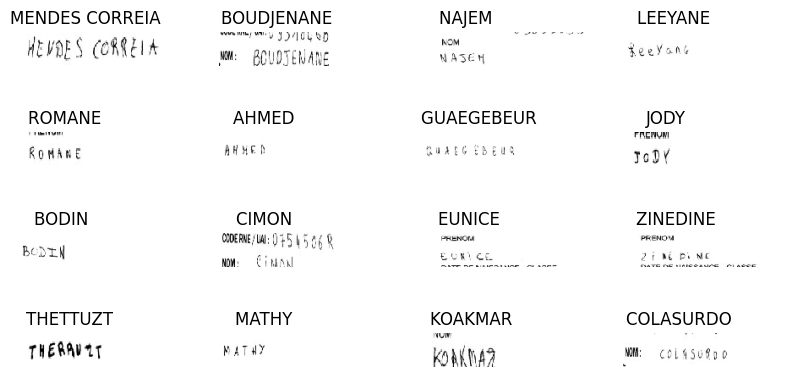

In [196]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    print('a')
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [197]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"), 
        vals_sparse, 
        ops.cast(label_shape, dtype="int64")
    )

@keras.saving.register_keras_serializable(package="customs", name="CTCLayer")
class CTCLayer(layers.Layer):
    # def __init__(self, name=None):
    #     super().__init__(name=name)
    #     self.loss_fn = ctc_batch_cost
    def __init__(self, trainable=True, dtype='float32', name=None, **kwargs):
        super().__init__(trainable=trainable, dtype=dtype, name=name, **kwargs)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model(num_conv_layers=2, filter_size=3, activation='tanh'):
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    x = input_img
    for i in range(num_conv_layers):
        x = layers.Conv2D(
            64,
            (filter_size, filter_size),
            activation=activation,
            kernel_initializer="he_normal",
            padding="same",
            name=f"Conv{i+1}",
        )(x)
        x = layers.MaxPooling2D((2, 2), name=f"pool{i+1}")(x)

    downscale_factor = 2 ** num_conv_layers
    new_shape = ((img_width // downscale_factor), (img_height // downscale_factor) * 64)    
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model()
model.summary()


Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 50, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 50, 256)   │    197,632 │ dropout_8[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (None, 50, 128)   │    164,352 │ bidirectional_16… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 38)    │      4,902 │ bidirectional_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 38)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 445,478 (1.70 MB)

 Trainable params: 445,478 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

In [198]:
# TODO restore epoch count.
epochs = 3
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/3
207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - loss: 623.0404 - val_loss: 397.6587
Epoch 2/3
207/207 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - loss: 404.5005 - val_loss: 393.1072
Epoch 3/3
207/207 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - loss: 400.4166 - val_loss: 388.6950


In [ ]:
model.save("./models/trained_model.keras")

In [199]:
test_dataset

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 40, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [203]:
preds = model.predict(test_dataset)

130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step


In [204]:
def ctc_decode2(y_pred):
    input_length = np.ones(preds.shape[0]) * preds.shape[1]
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
        inputs=y_pred, sequence_length=input_length
    )

    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))

    dec = (decoded_dense, log_prob)

    return dec

def decode_to_utf8(y_pred):
    y_pred = np.where(y_pred == -1, 1, y_pred)
    charst = num_to_char(y_pred)
    decoded_text_numpy = np.array(charst)
    decoded_text_utf8 = np.char.decode(decoded_text_numpy.astype('bytes'), 'utf-8')

    res_words = [''.join(filter(lambda x: x != ' ', row)) for row in decoded_text_utf8]

    return res_words

In [205]:
dec = ctc_decode2(preds)[0][0][
        :, :max_length
    ]
print(dec.shape)
# res = decode_to_utf8(dec)
# print(res)

for batch in test_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

print(len(batch_images))
print(len(batch_labels))



(2065, 20)
1
1


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 38)         │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,478 (1.70 MB)

 Trainable params: 445,478 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


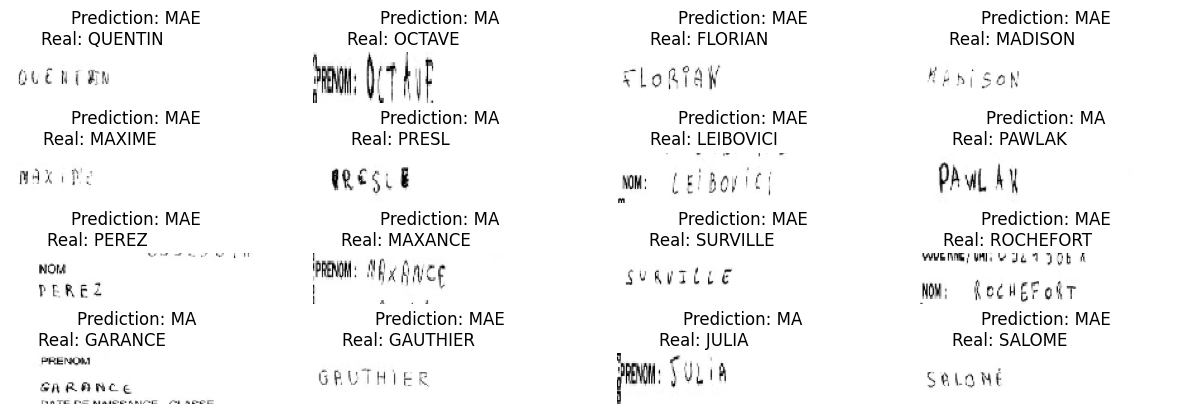

In [206]:
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()
#  Let's check results on some validation samples
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    # pred_texts = decode_batch_predictions(preds)

    dec = ctc_decode2(preds)[0][0][
        :, :max_length
    ]
    pred_texts = decode_to_utf8(dec)
    # pred_texts = pred_texts.astype(str)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}\nReal: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
# custom_objects = {
#     'CTCLayer': CTCLayer
# }
# model = keras.saving.load_model("./models/troche_trained.keras", custom_objects=custom_objects)

In [ ]:
def levenshtein(s1, s2):
    dp = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

    for i in range(len(s1) + 1):
        dp[i][0] = i
    for j in range(len(s2) + 1):
        dp[0][j] = j
    
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            if s1[i - 1] == s2[j - 1]:
                cost = 0
            else:
                cost = 1
            dp[i][j] = min(dp[i - 1][j] + 1,
                           dp[i][j - 1] + 1,
                           dp[i - 1][j - 1] + cost)
    return dp[len(s1)][len(s2)]

In [ ]:
total_distance = 0
num_samples = 0
for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    dec = ctc_decode2(preds)[0][0][
        :, :max_length
    ]
    pred_texts = decode_to_utf8(dec)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    for i in range(len(pred_texts)):
        total_distance += levenshtein(pred_texts[i], orig_texts[i])
        num_samples += 1


# Calculate and print the average Levenshtein distance
average_distance = total_distance / num_samples
print(f"Average Levenshtein Distance: {average_distance}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Average Lev

2024-05-23 15:54:43.118946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [165]:
def prepareSet(X,Y):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = (
    dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    return dataset


In [207]:
from sklearn.model_selection import KFold

data_array = train_csv.to_numpy()

kf = KFold(n_splits=2, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(data_array), 1):
    print("\n\n","-"*30, "fold:", fold, "-"*30, "\n")

    X_train, X_test = train_csv.iloc[train_index], train_csv.iloc[test_index]

    Y_test = [label.ljust(max_length) for label in list(X_test['IDENTITY'].astype(str))]
    X_test = [os.path.join(data_dir, img) for img in X_test['FILENAME']]

    Y_train = [label.ljust(max_length) for label in list(X_train['IDENTITY'].astype(str))]
    X_train = [os.path.join(data_dir, img) for img in X_train['FILENAME']]

    train_dataset = prepareSet(X_train, Y_train)
    test_dataset = prepareSet(X_test, Y_test)

    kmodel = build_model()
    epochs = 1
    # Add early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    # Train the model
    kmodel.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
    )
    kpreds = kmodel.predict(test_dataset)




 ------------------------------ fold: 1 ------------------------------ 

Tensor("args_1:0", shape=(), dtype=string)
Tensor("string_lookup_14_1/Identity:0", shape=(None,), dtype=int64)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("string_lookup_14_1/Identity:0", shape=(None,), dtype=int64)
130/130 ━━━━━━━━━━━━━━━━━━━━ 73s 405ms/step - loss: 721.1765 - val_loss: 410.1372
130/130 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step


 ------------------------------ fold: 2 ------------------------------ 

Tensor("args_1:0", shape=(), dtype=string)
Tensor("string_lookup_14_1/Identity:0", shape=(None,), dtype=int64)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("string_lookup_14_1/Identity:0", shape=(None,), dtype=int64)
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - loss: 737.6005 - val_loss: 420.3870
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step


In [208]:
for batch in test_dataset.take(1):
    kbatch_images = batch["image"]
    kbatch_labels = batch["label"]

    # preds = prediction_model.predict(batch_images)
    # pred_texts = decode_batch_predictions(preds)

    dec = ctc_decode2(kpreds)[0][0][
        :, :max_length
    ]
    kpred_texts = decode_to_utf8(dec)
    # pred_texts = pred_texts.astype(str)

    orig_texts = []
    for label in kbatch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(kpred_texts)):
        img = (kbatch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {kpred_texts[i]}\nReal: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

FailedPreconditionError: {{function_node __wrapped__CTCGreedyDecoder_device_/job:localhost/replica:0/task:0/device:CPU:0}} len(sequence_length) != batch_size.  len(sequence_length):  16 batch_size: 2065 [Op:CTCGreedyDecoder] name: 

a


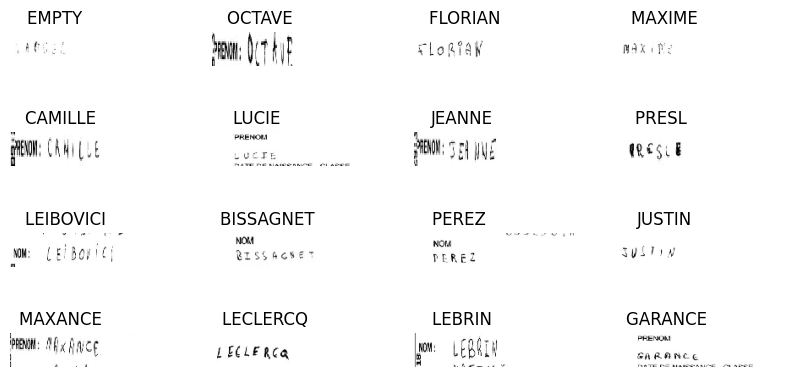

In [162]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    print('a')
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()